Loading and processing the dataset...
Training the model...
Accuracy of the model: 95.65%


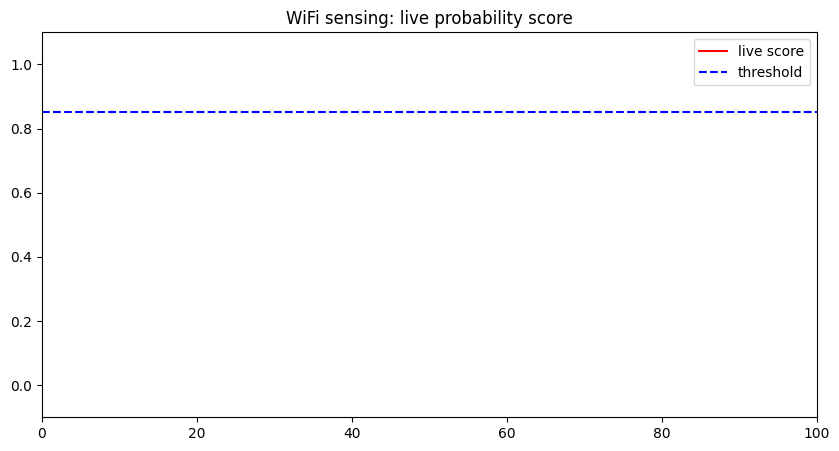

Error: ClearCommError failed (PermissionError(13, 'Access is denied.', None, 5))


In [ ]:
import serial                            # imports the 'pyserial' library. This library allows Python to communicate with the Serial Ports
import pandas as pd                      # imports the 'pandas' library which is used for handling data tables (CSV in our case)
import numpy as np                       # imports the 'numpy' library which is used for fast mathematical operations
import re                                # imports the 're' (Regular Expression) library. We use it to find patterns (numbers in our case) inside text 

# imports specific tool from 'sklearn' (Scikit-Learn) Machine Learning library
from sklearn.model_selection import train_test_split            # tool to split data into 'training' and 'testing' sets
from sklearn.ensemble import RandomForestClassifier             # the ML model we are using (a collection of silly decision trees)
from sklearn.metrics import accuracy_score                      # tools to grade the models performance

# Configuration
COM_PORT = 'COM4'                             # the COM port where the RX is connected
BAUD_RATE = 921600                            # baud rate for serial communication (matches the RX configuration)
training_file = "filtered_csi_dataset.csv"    # the name of the file used to train the model before seeing it's capabilities in real-time

print(f"Loading and processing the dataset...")

try:
    # reads the CSV file into a DataFrame (a table structure)
    # header = None -> tells pandas there are no column names in the first row
    # on_bad_lines = 'skip' -> ignores corrupted rows instead of crashing the program
    # engine = 'python' -> uses the Python parsing engine
    df = pd.read_csv(training_file, header = None, on_bad_lines = 'skip', engine = 'python')

    # standard error handling
except FileNotFoundError:
    print(f"Error: file {training_file} not found.")
    raise   # stops the program if the file is missing

# y_raw contains the 'answers' (0 for empty, 1 for person in room)
y_raw = df.iloc[:,0].values

# X_raw contains the 'questions' (the raw CSI data)
X_raw = df.iloc[:,4:].values

# the raw data is interleaved (real, imaginary, real, imaginary...)
# we extract the real parts by taking every 2nd column starting from index 0
# we extract the imaginary parts by taking every 2nd column starting from index 1
real_parts = X_raw[:, 0::2]
imaginary_parts = X_raw[:, 1::2]

# we calculate the amplitude (signal strength) using Pythagorean theorem
# sqrt(real^2 + imaginary^2)
X_amp = np.sqrt(real_parts**2 + imaginary_parts**2)

# calculate the average signal strength for each column (axis = 0) across the entire dataset
X_mean = np.mean(X_amp, axis = 0)

# calculate the standard deviation to measure how much the signal usually fluctuates
X_std = np.std(X_amp, axis = 0)

# apply Z-score standardization -> center data around 0 and scale it (add a small epsilon to avoid division by 0)
X_amp = (X_amp - X_mean) / (X_std + 0.00001)

# calculate the absolute difference between the current row and the previous row to detect motion
# prepend = X_amp[0:1] ensures the result has the same number of rows as the input
delta = np.abs(np.diff(X_amp, axis = 0, prepend = X_amp[0:1]))

# combines the amplitude (a static feature) with delta (a dynamic feature) into a large table
X_final = np.hstack([X_amp,delta])
print(f"Training the model...")

# here we will split the data into two parts:
# X_train, y_train (85%) is used to train the model
# X_test, y_test (15%) is used to test the model
X_train, X_test, y_train, y_test = train_test_split(X_final, y_raw, test_size = 0.15)

# we create a 'RandomForest' which consists of 100 decision trees (n_estimators = 100)
model = RandomForestClassifier(n_estimators = 100)

# the model looks at X_train (CSI patterns) and learns to associate them with y_train (labels)
model.fit(X_train, y_train)

# we ask the model to predict the labels for the test data (X_test)
# the model will not see the real answers (y_test) just yet
y_pred = model.predict(X_test)

# we compare the model's guesses (y_pred) with the real answers (y_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy * 100:.2f}%")

ser = None # initialize the serial connection variable as 'None' (empty)

try:       # the 'try' block let's us test a block of code for errors
    # Initialize Serial Connection (opens the specific serial port at the specified speed, 'timeout = 1' means it will wait a second for data before moving on)
    ser = serial.Serial(COM_PORT, BAUD_RATE, timeout = 0.1)
    
    ser.reset_input_buffer() # clear the buffer to get rid of old data
    
    probability_buffer = []    # list to save recent probability predictions for optimizations
    buffer_size = 10           # number of recent predictions to average (determines reaction speed)
    threshold = 0.85           # decision threshold 
    previous_ampl = None           # variable to store the previous packet's amplitude for delta calculation

    while True:
        try:
            ser.reset_input_buffer()   # clear the serial buffer to get rid of old data
            raw_line = ser.readline()  # read the most recent line of data available

            if not raw_line:
                continue
            
            # decodes the bytes to text (utf-8) and gets rid of unwanted spaces (.strip())
            # errors = 'ignore' is used to ignore corrupted characters
            line = raw_line.decode('utf-8', errors = 'ignore').strip()

            # check if the row starts with the key text we set
            if line.startswith("[CSI DATA]"):
                # re.findall(r'-?\d+',line) scans the entire line of text
                # r'-?\d+' -> searches for any group of digits (\d+)
                numbers_found = re.findall(r'-?\d+', line)

                # we check if the length of the CSI string is 384, if it is, we keep it
                if len(numbers_found) > 3 and numbers_found[2] == '384':
                    # [-384] -> we grab the last 384 numbers in the line (where the important data is)
                    csi_raw = [int(x) for x in numbers_found[-384:]]

                    # ignores the bad lines thus filtering the data
                    if len(csi_raw) >= 382:
                        # converts the Python list into a NumPy array (for time optimization)
                        csi_np = np.array(csi_raw)

                        # the raw data is interleaved (real, imaginary, real, imaginary...)
                        # we extract the real parts by taking every 2nd column starting from index 0
                        # we extract the imaginary parts by taking every 2nd column starting from index 1
                        real_part = csi_np[0::2]
                        imaginary_part = csi_np[1::2]
                        
                        # we calculate the amplitude (signal strength) using Pythagorean theorem
                        # sqrt(real^2 + imaginary^2)
                        ampl = np.sqrt(real_part**2 + imaginary_part**2)
                        
                        # ensures the live packet has the same number of columns as the training data
                        if ampl.shape[0] > X_mean.shape[0]:
                            ampl = ampl[:X_mean.shape[0]]

                        # standardize using the mean and std learned during training
                        ampl = (ampl - X_mean) / (X_std + 0.00001)

                        if previous_ampl is None:
                            delta = np.zeros_like(ampl)      # since we have no history, for the first packet delta will be 0
                            previous_ampl = ampl             # save the current packet as previous for the next iteration
                        else:
                            delta = np.abs(ampl - previous_ampl) # calculate the absolute difference between curremt packet and the previous one
                            previous_ampl = ampl             # update history

                        # combine aplitude and delta to match training data format
                        features = np.hstack([ampl, delta])

                        # reshape to (1, n_features) to make it a 2D array
                        features_ready = features.reshape(1,-1)

                        # get the probability that the room is not empty
                        probability = model.predict_proba(features_ready)[0][1]
                        
                        # adding the probability to the circular buffer
                        probability_buffer.append(probability)
                        if len(probability_buffer) > buffer_size:
                            probability_buffer.pop(0) # remove the oldest value to maintain buffer size

                        # calculate the median score (good filter)
                        avg_score = np.median(probability_buffer)  

                        # compare score against the calibrated threshold
                        if avg_score <= threshold:
                            info = "not empty"
                        else:
                            info = "empty    "
                        
                        print(f"RSSI: {numbers_found[1]}dBm, SCORE: {avg_score:.4f}, STATUS: {info}", end = '\r')    
        except (ValueError, IndexError):
            continue

# the 'except' block is used for error handling outside the loop         
except serial.SerialException as e:
    print(f"Error: {e}")                        # if the port is busy or the cable is unplugged
except KeyboardInterrupt:
    print(f"Testing interrupted by User.")    # if we press 'Interrupt' in Jupyter

# the 'finally' block will be executed regardless if the try block raises an error or not
finally:
    if ser is not None and ser.is_open: # check if the serial connection was opened
        ser.close()                     # if it was opened, we will close the USB port